# PRÁCTICA 1 - Análisis Exploratorio

***Entidades***
* Empleados
* Dependencias
* Tipos
* Años

### SETUP

In [23]:
import pandas as pd
import seaborn as sns
import numpy as np
import openpyxl
from openpyxl import load_workbook
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.stats import shapiro
from scipy.stats import kruskal
from scipy.stats import rankdata
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [24]:
def clean_column_names(df):
    df.columns = df.columns.str.replace(" ", "_") 
    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.strip()
    return df

In [25]:
pd.options.display.float_format = '{:,.2f}'.format

### READ DATA

In [26]:
uanl = pd.read_csv("typed_uanl.csv")
clean_column_names(uanl)
uanl["anio"] = uanl["fecha"].str[:4]
uanl["fecha"] = pd.to_datetime(uanl["fecha"], format="%Y-%m-%d")
uanl["dependencia"] = uanl["dependencia"].str.strip().str.replace('´', '')
#uanl.head(5)

In [27]:
#DEPENDENCIAS QUE CAMBIARON
changes =pd.DataFrame( pd.read_excel("changes.xlsx"))
clean_column_names(changes)


,initial,change
0,CENTRO DE VINCULACION SOCIAL Y EMPRESARIAL,SRIA. DE INVESTIGACIÓN CIENTÍFICA Y DESARROLLO...
1,DIRECCIÓN DE DESARROLLO DE MODELOS TECNOLÓGICOS,DIRECCIÓN DE INNOVACIÓN Y DESARROLLO DE MODELO...
2,DIRECCION DE COMUNICACION INSTITUCIONAL,DIRECCION DE COMUNICACION INSTITUCIONAL Y RELA...
3,DIRECCIÓN DE RELACIONES INTERNACIONALES,SECRETARIA DE RELACIONES INTERNACIONALES
4,WORLD TRADE CENTER MONTEREY-UANL,CENTRO DE DESARROLLO EMPRESARIAL
5,DIRECCIÓN DE PLANEACIÓN ESTRATÉGICA EN INNOVACIÓN,DIRECCIÓN DE PLANEACIÓN ESTRATÉGICA EN INNOVACIÓN
6,DIRECCION DE TECNOLOGIAS DE INFORMACION,DIRECCION GENERAL DE TECNOLOGÍAS Y DESARROLLO ...
7,DIRECCIÓN DE INNOVACIÓN Y EMPRENDIMIENTO,DIRECCIÓN DE EMPRENDIMIENTO Y DESARROLLO EMPRE...
8,DIRECCIÓN DE INVESTIGACIÓN EDUCATIVA,SRIA. DE INVESTIGACIÓN CIENTÍFICA Y DESARROLLO...
9,DIRECCIÓN ADMINISTRATIVA DE LA SIID,DIRECCIÓN DE DESARROLLO INSTITUCIONAL ACADÉMICO


In [28]:
uanl2 = uanl.merge(changes, left_on='dependencia', right_on='change', how='left')
uanl2.loc[~uanl2['initial'].isna(), 'dependencia'] = uanl2['initial']
uanl= uanl2.drop(["initial","change"],axis=1)

In [29]:
print(f"Se tiene información que va desde {min(uanl["fecha"])} hasta {max(uanl["fecha"])} ")

Se tiene información que va desde 2019-12-01 00:00:00 hasta 2024-01-01 00:00:00 


In [30]:
print(f"En nuestra base se consideran {len(uanl["nombre"].unique())} empleados que han laborado en {len(uanl["dependencia"].unique())} dependencias, clasificadas en {len(uanl["tipo"].unique())} tipos")

En nuestra base se consideran 21034 empleados que han laborado en 141 dependencias, clasificadas en 6 tipos


In [31]:
emp = uanl.groupby('nombre')['fecha'].agg(MasAntigua='min', MasReciente='max').reset_index()
emp_nuevos = int(emp.loc[emp["MasAntigua"] != "2019-12-01"]["nombre"].count())
emp_bajas = int(emp.loc[emp["MasReciente"] != "2024-01-01"]["nombre"].count())
print(f"Durante el periodo se tiene registro de {emp_nuevos} ingresos y {emp_bajas} bajas de empleados")


Durante el periodo se tiene registro de 6628 ingresos y 9251 bajas de empleados


In [32]:
dep = uanl.groupby('dependencia')['fecha'].agg(MasAntigua='min', MasReciente='max').reset_index()
#dep.to_excel('dependencias.xlsx', index=False)
dep_old = int(dep.loc[dep["MasReciente"] != "2024-01-01"]["dependencia"].count())
dep_new = int(dep.loc[dep["MasAntigua"] != "2019-12-01"]["dependencia"].count())
print(f"Durante el periodo se inaguraron {dep_new} dependencias y se clausuraron {dep_old}.")

Durante el periodo se inaguraron 28 dependencias y se clausuraron 4.


### Estadística Descriptiva

In [33]:
uanl.agg({'sueldo_neto': ['sum', 'count', 'mean', 'min', 'max','std']})

,sueldo_neto
sum,"9,060,572,585.29"
count,"636,201.00"
mean,"14,241.68"
min,175.41
max,"147,051.59"
std,"9,578.44"


In [34]:
uanl.groupby("anio").agg({'sueldo_neto': ['sum', 'count', 'mean', 'min', 'max']})

sueldo_neto                                    
                  sum   count      mean    min        max
anio                                                     
2019   153,327,764.18   14410 10,640.37 294.44  86,245.29
2020 1,973,906,758.99  165182 11,949.89 175.41  98,881.96
2021 2,094,128,923.55  149425 14,014.58 187.54 138,744.51
2022 2,168,514,469.71  141811 15,291.58 189.65 140,739.88
2023 2,489,281,710.50  153571 16,209.32 230.03 147,051.59
2024   181,412,958.36   11802 15,371.37 825.27 111,868.46

In [35]:
mean_sueldo = uanl[["anio",'sueldo_neto']].groupby("anio").mean()
mean_sueldo = mean_sueldo.reset_index().rename(columns={"anio": "anio", "sueldo_neto": "sueldo_promedio"})
std_sueldo = uanl[["anio",'sueldo_neto']].groupby("anio").std().reset_index().rename(columns={"anio": "anio", "sueldo_neto": "std_dev_sueldo"})

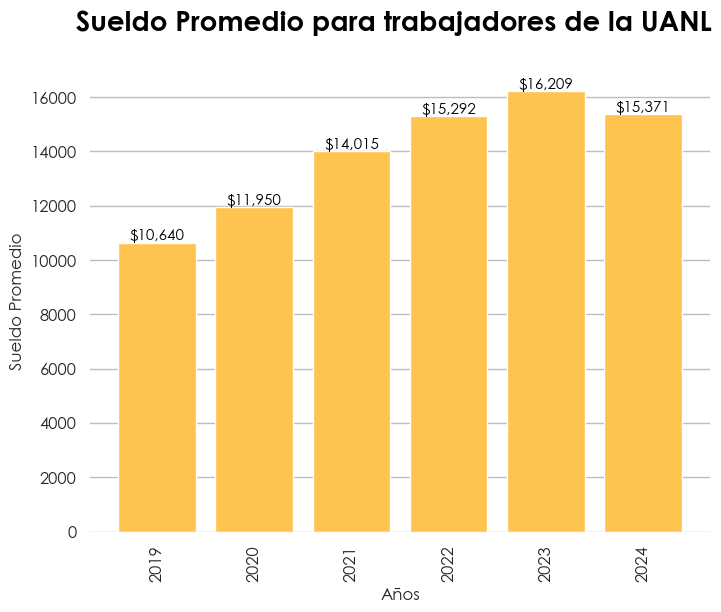

In [36]:
fuente = "Century Gothic"
fig, ax = plt.subplots(figsize=(8, 6))
plt.suptitle(f' Sueldo Promedio para trabajadores de la UANL',size = 20,fontname = fuente,fontweight = 'bold',
             color = 'black')
plt.xticks(size=12,rotation=90,fontname=fuente)
plt.yticks(size=12,fontname=fuente)
plt.ylabel('Sueldo Promedio',fontname = fuente,size=12)
plt.xlabel('Años',fontname = fuente,size=12)
plt.bar(mean_sueldo["anio"], mean_sueldo["sueldo_promedio"],color="#fec44f")
plt.box(on=None)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#bdbdbd')
for bar in ax.patches:
        bar_value = bar.get_height()
        text = "$" + f"{bar_value:,.0f}"
        text_x = bar.get_x() + bar.get_width() / 2
        text_y = bar.get_y() + bar_value
        ax.text(text_x, text_y, text, ha='center',
          va='bottom', color="black",
          size=11, fontname=fuente)

### Estadística por Agrupaciones

In [37]:
def analysis_tipo(df: pd.DataFrame)-> pd.DataFrame:
    df_by_type = df.groupby(["tipo", "anio"]).agg({'sueldo_neto': ['sum', 'count', 'mean', 'min', 'max','std']})
    df_by_type = df_by_type.reset_index()
    df_by_type.columns = ['tipo', 'anio', 'suma_total_sueldos', 'conteo_sueldos_pagados', 'promedio_sueldo', 'salario_minimo', 'salario_maximo','desviacion']
    return df_by_type

analysis_tipo(uanl)



,tipo,anio,suma_total_sueldos,conteo_sueldos_pagados,promedio_sueldo,salario_minimo,salario_maximo,desviacion
0,ADMIN,2019,"18,235,639.07",1732,"10,528.66","1,868.27","81,117.27","9,379.47"
1,ADMIN,2020,"246,307,007.52",20830,"11,824.63",177.20,"92,810.86","10,312.60"
2,ADMIN,2021,"248,742,064.04",17842,"13,941.38",544.11,"121,781.67","11,004.02"
3,ADMIN,2022,"224,141,735.48",16604,"13,499.26",198.64,"140,205.63","8,882.02"
4,ADMIN,2023,"265,607,486.83",18418,"14,421.08",319.14,"147,051.59","9,118.37"
5,ADMIN,2024,"21,309,562.04",1568,"13,590.28",962.70,"111,868.46","8,866.98"
6,CENTRO,2019,"5,562,617.36",561,"9,915.54","1,100.22","81,221.97","8,189.13"
7,CENTRO,2020,"72,076,014.53",6548,"11,007.33","1,167.80","90,359.69","8,804.78"
8,CENTRO,2021,"76,278,090.86",5731,"13,309.73","1,515.67","120,970.94","9,757.10"
9,CENTRO,2022,"73,760,019.57",5643,"13,071.06",245.38,"92,446.62","6,749.77"


In [38]:
def analysis_dependencia(df_complete: pd.DataFrame)-> pd.DataFrame:
    df_by_dep = df_complete.groupby(["dependencia", "anio"]).agg({'sueldo_neto': ['mean']})
    df_by_dep = df_by_dep.reset_index()
    df_by_dep.columns = ['dependencia', 'anio', 'promedio_sueldo']
    return df_by_dep

top = analysis_dependencia(uanl)

In [39]:
top[top["anio"]=="2023"].sort_values(by="promedio_sueldo",ascending=False)

,dependencia,anio,promedio_sueldo
222,DIRECCION DE UNIDADES ACADEMICAS,2023,"43,254.72"
248,DIRECCION RESPONSABILIDAD SOCIAL UNIVERSITARIA...,2023,"30,561.57"
713,RECTORIA,2023,"29,158.80"
737,SECRETARIA DE SUSTENTABILIDAD,2023,"24,015.34"
679,INST. DE INVESTIGACIONES SOCIALES,2023,"23,425.32"
...,...,...,...
136,DEPTO. DE PERSONAL,2023,"11,233.08"
142,DIRECCION DE ACTIVIDADES ESTUDIANTILES,2023,"11,086.24"
673,IMPRENTA UNIVERSITARIA,2023,"10,825.67"
685,JUNTA DE GOBIERNO,2023,"10,824.39"


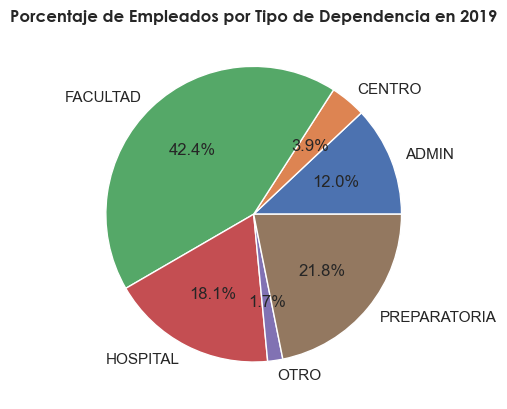

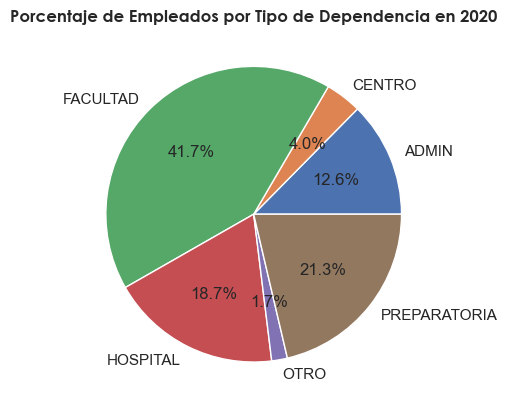

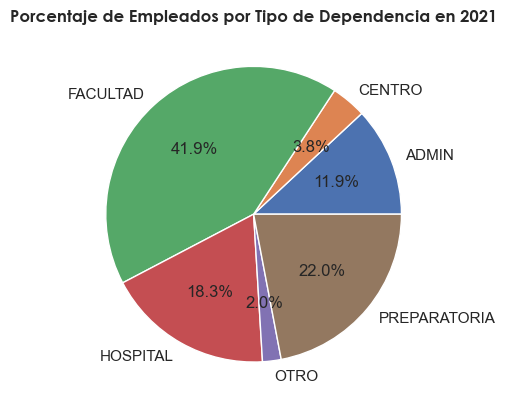

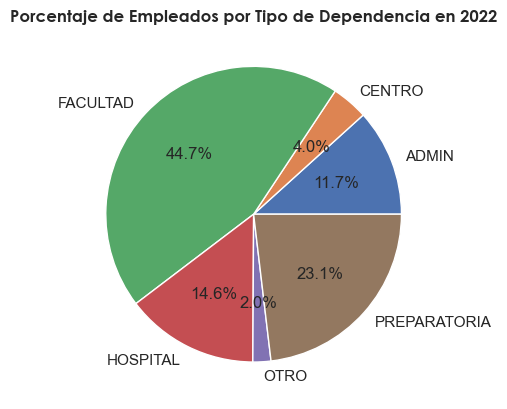

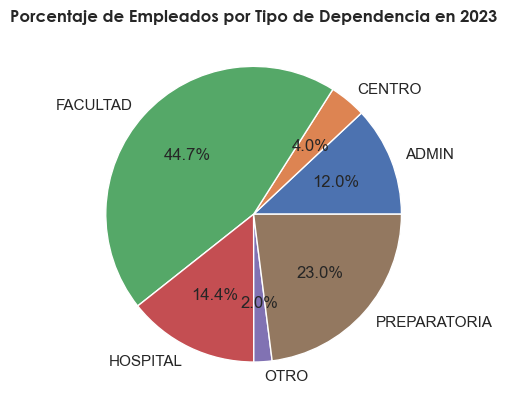

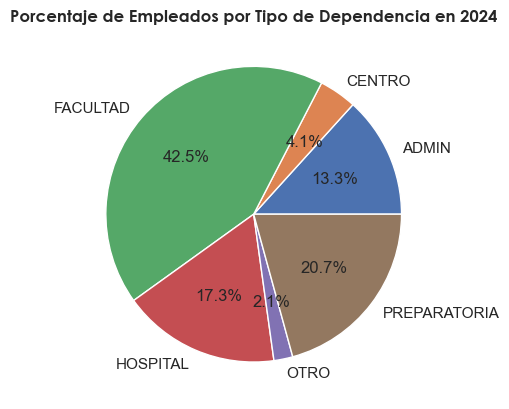

In [40]:
nombres_por_tipo_anio = uanl.groupby(["tipo", "anio"])["nombre"].count().reset_index()

for anio in nombres_por_tipo_anio["anio"].unique():
    datos_anio = nombres_por_tipo_anio[nombres_por_tipo_anio["anio"] == anio]
    tipos = datos_anio["tipo"]
    cantidades = datos_anio["nombre"]
    
    plt.figure() 
    plt.pie(cantidades, labels=tipos, autopct="%1.1f%%")
    plt.title(f"Porcentaje de Empleados por Tipo de Dependencia en {anio}",fontname=fuente,fontweight="bold")

plt.show()

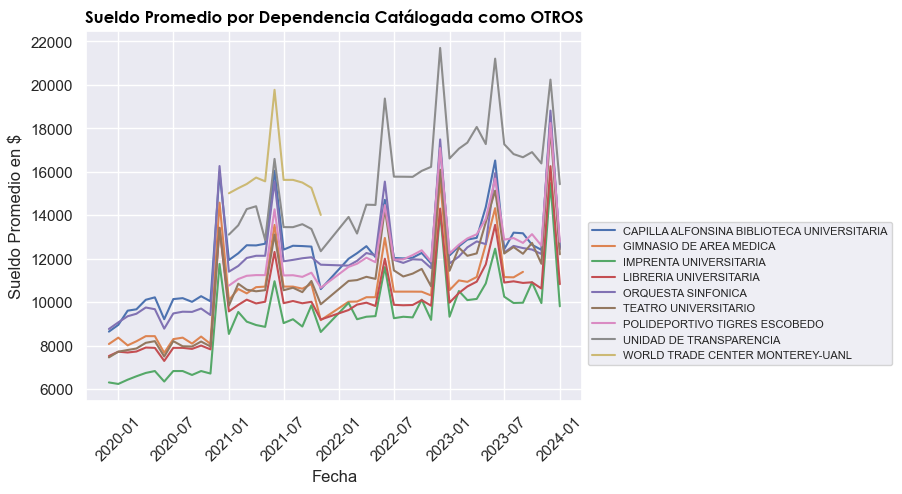

In [41]:

uanl_tipo = uanl[uanl['tipo'] == "OTRO"]
uanl_promedio = uanl_tipo.groupby(['fecha', 'dependencia'])['sueldo_neto'].mean().reset_index()
for dependencia in uanl_promedio['dependencia'].unique():
        data_dependencia = uanl_promedio[uanl_promedio['dependencia'] == dependencia]
        plt.plot(data_dependencia['fecha'], data_dependencia['sueldo_neto'], label=dependencia)
        plt.legend(loc='best', bbox_to_anchor=(1, 0.5), fontsize=8)
        plt.xlabel('Fecha')
        plt.ylabel('Sueldo Promedio en $')
        plt.title(f'Sueldo Promedio por Dependencia Catálogada como OTROS',size = 12,fontname = fuente,fontweight = 'bold',
             color = 'black')
        plt.xticks(rotation=45)
plt.show()

### ANOVA

In [42]:
#NORMALIDAD
# Prueba de Shapiro-Wilk
stat, pvalue = shapiro(analysis_tipo(uanl)['suma_total_sueldos'])

print(f"Estadístico de prueba: {stat}")
print(f"Valor p: {pvalue}")
if pvalue > 0.05:
    print("Los datos tienen distribución normal.")
else:
    print("Los datos no cumplen el supuesto de normalidad.")

Estadístico de prueba: 0.720519865639476
Valor p: 6.038124804118489e-07
Los datos no cumplen el supuesto de normalidad.


In [43]:
df_by_type = uanl.groupby(["tipo", "anio"]).agg({'sueldo_neto': ['sum']})
df_by_type = df_by_type.reset_index()
df_by_type.columns = ['tipo', 'anio', 'suma_total_sueldos']
admin = df_by_type[df_by_type['tipo'] == 'ADMIN']['suma_total_sueldos']
centro = df_by_type[df_by_type['tipo'] == 'CENTRO']['suma_total_sueldos']
facu = df_by_type[df_by_type['tipo'] == 'FACULTAD']['suma_total_sueldos']
hosp = df_by_type[df_by_type['tipo'] == 'HOSPITAL']['suma_total_sueldos']
otro = df_by_type[df_by_type['tipo'] == 'OTRO']['suma_total_sueldos']
prepa = df_by_type[df_by_type['tipo'] == 'PREPARATORIA']['suma_total_sueldos']

#Kruskal-Wallis
stat, pvalue = kruskal(admin,centro,facu,hosp,otro,prepa)
print(f"Estadístico de prueba: {stat}")
print(f"Valor p: {pvalue}")
if pvalue > 0.05:
    print("No se encontraron diferencias significativas entre los grupos.")
else:
    print("Se encontraron diferencias significativas entre los grupos.")

Estadístico de prueba: 15.894894894894904
Valor p: 0.007150649065847432
Se encontraron diferencias significativas entre los grupos.


C:\Users\HP\AppData\Local\Temp\ipykernel_15792\1258067241.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")


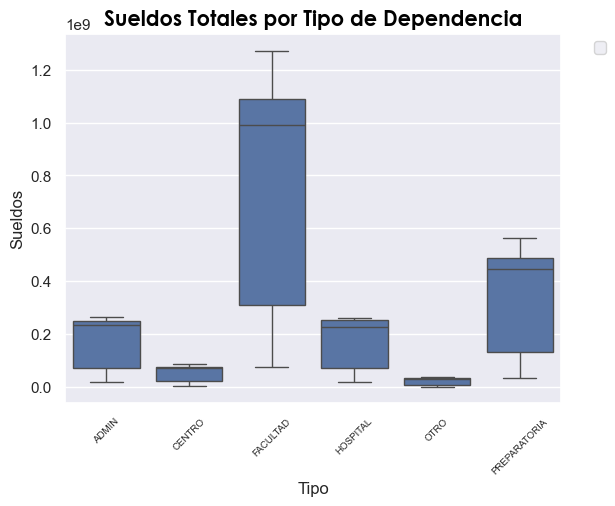

In [44]:
sns.set()

sns.boxplot(x="tipo", y="suma_total_sueldos", data=df_by_type)

ax = plt.gca()
outliers = [flier.get_path() for flier in ax.artists[6:]]

for flier in outliers:
    flier.set_facecolor("red")
    flier.set_markersize(3)

plt.xlabel("Tipo")
plt.ylabel("Sueldos")
plt.title("Sueldos Totales por Tipo de Dependencia",size = 15,fontname = fuente,fontweight = 'bold',
             color = 'black')

plt.xticks(rotation=45,fontsize=7)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

In [45]:
tukey_data = df_by_type.drop("anio",axis=1)
tukey = pairwise_tukeyhsd(endog=tukey_data['suma_total_sueldos'],
                          groups=tukey_data['tipo'],
                          alpha=0.05)

print(tukey)


                Multiple Comparison of Means - Tukey HSD, FWER=0.05                 
 group1     group2        meandiff    p-adj       lower            upper      reject
------------------------------------------------------------------------------------
   ADMIN       CENTRO -117199946.4767 0.9615  -551931410.5882  317531517.6348  False
   ADMIN     FACULTAD  584937627.4483 0.0037   150206163.3368 1019669091.5598   True
   ADMIN     HOSPITAL     -1293437.41    1.0  -436024901.5215  433438026.7015  False
   ADMIN         OTRO -147535005.2183 0.9033  -582266469.3298  287196458.8932  False
   ADMIN PREPARATORIA  166842697.5583 0.8485  -267888766.5532  601574161.6698  False
  CENTRO     FACULTAD   702137573.925 0.0004   267406109.8135 1136869038.0365   True
  CENTRO     HOSPITAL  115906509.0667 0.9633  -318824955.0448  550637973.1782  False
  CENTRO         OTRO  -30335058.7417 0.9999  -465066522.8532  404396405.3698  False
  CENTRO PREPARATORIA   284042644.035 0.3728  -150688820.0765  71

In [46]:
facultades = uanl[uanl['tipo'] == 'FACULTAD'].drop(["tipo","fecha","nombre","anio"],axis=1)
promedios_ordenados = facultades.groupby('dependencia')['sueldo_neto'].mean().sort_values(ascending=False)
promedios_ordenados


dependencia
FAC. DE ING. MECANICA Y ELECTRICA                             20,479.73
FAC. DE CIENCIAS DE LA TIERRA                                 20,269.28
FAC. DE CIENCIAS BIOLOGICAS                                   18,374.86
FAC. DE MEDICINA                                              18,330.53
FAC. DE ECONOMIA                                              18,227.39
FAC. DE CIENCIAS FISICO-MATEMATICAS                           17,389.04
FAC. DE AGRONOMIA                                             16,954.20
FAC. DE CIENCIAS FORESTALES                                   16,802.13
FAC. DE ODONTOLOGIA                                           16,754.41
FACULTAD DE TRABAJO SOCIAL Y DESARROLLO HUMANO                16,574.01
FAC. DE CIENCIAS QUIMICAS                                     16,397.89
FACULTAD DE CIENCIAS POLÍTICAS Y RELACIONES INTERNACIONALES   15,844.48
FAC. DE ENFERMERIA                                            15,771.81
FAC. DE MED. VETERINARIA Y ZOOT.                    

C:\Users\HP\AppData\Local\Temp\ipykernel_15792\1300959830.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")


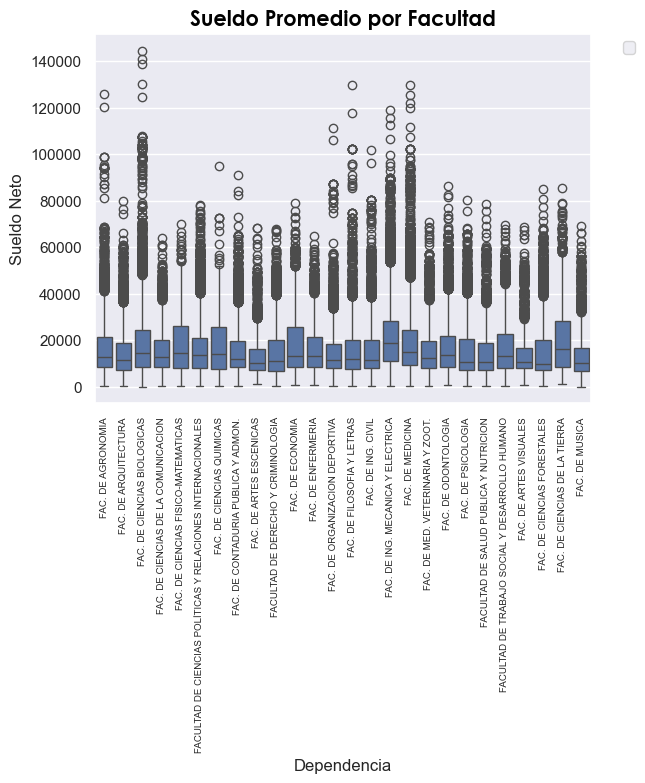

In [47]:
sns.set()

sns.boxplot(x="dependencia", y="sueldo_neto", data=facultades)

ax = plt.gca()
outliers = [flier.get_path() for flier in ax.artists[6:]]

for flier in outliers:
    flier.set_facecolor("red")
    flier.set_markersize(3)

plt.xlabel("Dependencia")
plt.ylabel("Sueldo Neto")
plt.title("Sueldo Promedio por Facultad",size = 15,fontname = fuente,fontweight = 'bold',
             color = 'black')

plt.xticks(rotation=90,fontsize=7)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

In [48]:
uanl[uanl["dependencia"]=="FAC. DE ING. MECANICA Y ELECTRICA"][uanl["anio"]=="2024"].sort_values("sueldo_neto",ascending=False)

C:\Users\HP\AppData\Local\Temp\ipykernel_15792\412576588.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  uanl[uanl["dependencia"]=="FAC. DE ING. MECANICA Y ELECTRICA"][uanl["anio"]=="2024"].sort_values("sueldo_neto",ascending=False)


,nombre,sueldo_neto,dependencia,fecha,tipo,anio
631054,JAIME ARTURO CASTILLO ELIZONDO,"89,498.95",FAC. DE ING. MECANICA Y ELECTRICA,2024-01-01,FACULTAD,2024
631355,ROGELIO GUILLERMO GARZA RIVERA,"88,830.99",FAC. DE ING. MECANICA Y ELECTRICA,2024-01-01,FACULTAD,2024
631225,MARIO ALBERTO GONZALEZ DE LEON,"83,597.10",FAC. DE ING. MECANICA Y ELECTRICA,2024-01-01,FACULTAD,2024
630989,FRANCISCO GERARDO TREVIĂ‘O BARRERA,"69,651.30",FAC. DE ING. MECANICA Y ELECTRICA,2024-01-01,FACULTAD,2024
630826,ARNULFO TREVIĂ‘O CUBERO,"68,159.59",FAC. DE ING. MECANICA Y ELECTRICA,2024-01-01,FACULTAD,2024
...,...,...,...,...,...,...
631128,JOSE ROLANDO PUENTE ZEFERINO,"5,220.89",FAC. DE ING. MECANICA Y ELECTRICA,2024-01-01,FACULTAD,2024
631338,RICARDO ESCOBAR RODRIGUEZ,"4,701.68",FAC. DE ING. MECANICA Y ELECTRICA,2024-01-01,FACULTAD,2024
630956,ERNESTO ABELARDO MELGAREJO AYALA,"4,357.08",FAC. DE ING. MECANICA Y ELECTRICA,2024-01-01,FACULTAD,2024
631114,JOSE JAVIER BARRIOS LUNA,"4,291.36",FAC. DE ING. MECANICA Y ELECTRICA,2024-01-01,FACULTAD,2024
